In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from bs4 import BeautifulSoup
import re
import json
import os
from tqdm import tqdm
import time
import random
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
import warnings

warnings.filterwarnings('ignore')

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /home/maksudovaza/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/maksudovaza/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

**Цель** - собрать небольшой QA-датасет на узкоспециализированные темы (научных статей) на русском языке для fine-tuning'а.

# Скачаем сэмпл из датасета SQuAD с Hugging Face

In [13]:
from datasets import load_dataset
squad = load_dataset("squad", split="train")
squad

Using the latest cached version of the dataset since squad couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'plain_text' at /home/maksudovaza/.cache/huggingface/datasets/squad/plain_text/0.0.0/7b6d24c440a36b6815f21b70d25016731768db1f (last modified on Thu Apr  3 20:25:39 2025).


Dataset({
    features: ['id', 'title', 'context', 'question', 'answers'],
    num_rows: 87599
})

In [2]:
def load_squad_dataset():
    try:
        from datasets import load_dataset
        squad = load_dataset("squad", split="train")

        data = []
        for example in tqdm(squad, desc="Processing SQuAD examples"):
            context = example["context"]
            for question, answer_text, answer_start in zip(
                [example["question"]],
                example["answers"]["text"],
                example["answers"]["answer_start"]
            ):
                data.append({
                    "document": context,
                    "question": question,
                    "answer": answer_text,
                    "source": "SQuAD",
                    "document_type": "Wikipedia Article"
                })

        df_squad = pd.DataFrame(data)
        return df_squad.sample(n=1000, random_state=42)

    except ImportError:
        test_data = []
        for i in range(100):
            test_data.append({
                "document": f"This is a sample document about topic {i}. It contains information that can be used for question answering.",
                "question": f"What is the topic of document {i}?",
                "answer": f"topic {i}",
                "source": "SQuAD",
                "document_type": "Wikipedia Article"
            })
        return pd.DataFrame(test_data)

df_squad = load_squad_dataset()
print(f"Загружено {len(df_squad)} примеров из SQuAD")
df_squad.head()


Processing SQuAD examples: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87599/87599 [00:08<00:00, 10873.29it/s]


Загружено 1000 примеров из SQuAD


,document,question,answer,source,document_type
9983,The world's first institution of technology or...,What year was the Banská Akadémia founded?,1735,SQuAD,Wikipedia Article
43267,The standard specifies how speed ratings shoul...,What is another speed that can also be reporte...,SOS-based speed,SQuAD,Wikipedia Article
81021,The most impressive and famous of Sumerian bui...,Where were the use of advanced materials and t...,Sumerian temples and palaces,SQuAD,Wikipedia Article
49374,Ann Arbor has a council-manager form of govern...,Who is elected every even numbered year?,mayor,SQuAD,Wikipedia Article
53414,"Shortly before his death, when he was already ...",What was the purpose of top secret ICBM commit...,decide on the feasibility of building an ICBM ...,SQuAD,Wikipedia Article


In [15]:
df_squad['question'][:10].unique()

array(['What year was the Banská Akadémia founded?',
       'What is another speed that can also be reported by the camera?',
       'Where were the use of advanced materials and techniques on display in Sumer?',
       'Who is elected every even numbered year?',
       'What was the purpose of top secret ICBM committee?',
       'What conferences became a requirement after Vatican II?',
       'Who does M fight with?',
       'How many species of fungi have been found on Antarctica?',
       'After losing the battle of Guilford Courthouse, Cornawallis moved his troops where?',
       'What is the Olympic Torch made from?'], dtype=object)

# Проскрапим абстракты научных статей с arXiv


In [3]:
def scrape_arxiv_abstracts(max_papers=100):
    categories = [
        'cs.AI', 'cs.CL', 'cs.CV', 'cs.LG',  # Компьютерные науки
        'math.ST', 'stat.ML',                 # Математика и статистика
        'q-bio',                             # Квантовая биология
        'quant-ph'                           # Квантовая физика
    ]

    papers = []
    for category in tqdm(categories, desc="Scraping categories"):
        url = f'http://export.arxiv.org/api/query?search_query=cat:{category}&max_results={max_papers//len(categories)}'
        response = requests.get(url)

        if response.status_code == 200:
            soup = BeautifulSoup(response.text, "html.parser") #'xml')
            entries = soup.find_all('entry')

            for entry in entries:
                title = entry.find('title').text.strip()
                abstract = entry.find('summary').text.strip()
                authors = [author.find('name').text for author in entry.find_all('author')]
                categories = [t.get('term') for t in entry.find_all('category')]

                papers.append({
                    'title': title,
                    'abstract': abstract,
                    'authors': ", ".join(authors),
                    'categories': categories
                })

        time.sleep(3)

    return pd.DataFrame(papers)

def generate_qa_pairs(abstracts_df):
    """Генерирует вопросно-ответные пары из абстрактов статей."""
    qa_pairs = []

    for index, row in tqdm(abstracts_df.iterrows(), total=len(abstracts_df), desc="Generating QA pairs"):
        abstract = row['abstract']
        title = row['title']

        sentences = re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s', abstract) # разбиваем абстракт на предложения
        if len(sentences) < 3:
            continue

        num_questions = min(3, len(sentences)) # cоздаем 2-3 вопроса по абстракту

        # Базовый вопрос
        qa_pairs.append({
            "document": abstract,
            "question": f"What is the main topic of the paper titled '{title}'?",
            "answer": sentences[0] if sentences else "Not enough information",
            "source": "arXiv",
            "document_type": "Scientific Abstract"
        })

        # Дополнительное извлечение информации из абстракта
        if len(sentences) > 1:
            qa_pairs.append({
                "document": abstract,
                "question": "What methods or approaches are used in this research?",
                "answer": sentences[1] if len(sentences) > 1 else "Not specified in the abstract",
                "source": "arXiv",
                "document_type": "Scientific Abstract"
            })

        if len(sentences) > 2:
            qa_pairs.append({
                "document": abstract,
                "question": "What are the key findings or results of this research?",
                "answer": sentences[-1],
                "source": "arXiv",
                "document_type": "Scientific Abstract"
            })

    return pd.DataFrame(qa_pairs)

def get_arxiv_qa_dataset(max_papers=100):
    try:
        # Пробуем скрейпить arXiv
        abstracts_df = scrape_arxiv_abstracts(max_papers)
        qa_dataset = generate_qa_pairs(abstracts_df)
        return qa_dataset
    except Exception as e:
        print(f"Ошибка при скрейпинге arXiv: {e}")
        test_data = []
        for i in range(100):
            test_data.append({
                "document": f"Abstract {i}: This research paper investigates the application of neural networks to solve complex problems in domain {i}. We propose a novel approach that combines transformer architectures with reinforcement learning. Our results show significant improvements over baseline methods.",
                "question": "What method is proposed in this research?",
                "answer": "A novel approach that combines transformer architectures with reinforcement learning",
                "source": "arXiv",
                "document_type": "Scientific Abstract"
            })
            test_data.append({
                "document": f"Abstract {i}: This research paper investigates the application of neural networks to solve complex problems in domain {i}. We propose a novel approach that combines transformer architectures with reinforcement learning. Our results show significant improvements over baseline methods.",
                "question": "What were the results of the research?",
                "answer": "Significant improvements over baseline methods",
                "source": "arXiv",
                "document_type": "Scientific Abstract"
            })
        return pd.DataFrame(test_data)

df_arxiv = get_arxiv_qa_dataset(max_papers=50)
print(f"Создано {len(df_arxiv)} вопросно-ответных пар из arXiv")
df_arxiv.head()


Generating QA pairs: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 222/222 [00:00<00:00, 3373.73it/s]

Создано 561 вопросно-ответных пар из arXiv


,document,question,answer,source,document_type
0,Because of their occasional need to return to ...,What is the main topic of the paper titled 'Dy...,Because of their occasional need to return to ...,arXiv,Scientific Abstract
1,Because of their occasional need to return to ...,What methods or approaches are used in this re...,"In this paper, we present a method by which\nb...",arXiv,Scientific Abstract
2,Because of their occasional need to return to ...,What are the key findings or results of this r...,The technique developed is a variant of depend...,arXiv,Scientific Abstract
3,Market price systems constitute a well-underst...,What is the main topic of the paper titled 'A ...,Market price systems constitute a well-underst...,arXiv,Scientific Abstract
4,Market price systems constitute a well-underst...,What methods or approaches are used in this re...,In a market-oriented programming approach\nto ...,arXiv,Scientific Abstract


In [4]:
df_arxiv['question'][:10].unique()

array(["What is the main topic of the paper titled 'Dynamic Backtracking'?",
       'What methods or approaches are used in this research?',
       'What are the key findings or results of this research?',
       "What is the main topic of the paper titled 'A Market-Oriented Programming Environment and its Application to\n  Distributed Multicommodity Flow Problems'?",
       "What is the main topic of the paper titled 'An Empirical Analysis of Search in GSAT'?",
       "What is the main topic of the paper titled 'The Difficulties of Learning Logic Programs with Cut'?"],
      dtype=object)

In [5]:
def merge_datasets(df1, df2):
    merged_df = pd.concat([df1, df2], ignore_index=True)

    merged_df['document_length'] = merged_df['document'].apply(len)
    merged_df['question_length'] = merged_df['question'].apply(len)
    merged_df['answer_length'] = merged_df['answer'].apply(len)

    merged_df['answer_to_document_ratio'] = merged_df['answer_length'] / merged_df['document_length']

    for col in ['document', 'question', 'answer']:
        merged_df[col] = merged_df[col].str.lower()

    return merged_df

final_dataset = merge_datasets(df_squad, df_arxiv)
print(f"Финальный датасет содержит {len(final_dataset)} записей")
final_dataset.head()

Финальный датасет содержит 1561 записей


,document,question,answer,source,document_type,document_length,question_length,answer_length,answer_to_document_ratio
0,the world's first institution of technology or...,what year was the banská akadémia founded?,1735,SQuAD,Wikipedia Article,608,42,4,0.006579
1,the standard specifies how speed ratings shoul...,what is another speed that can also be reporte...,sos-based speed,SQuAD,Wikipedia Article,890,62,15,0.016854
2,the most impressive and famous of sumerian bui...,where were the use of advanced materials and t...,sumerian temples and palaces,SQuAD,Wikipedia Article,578,76,28,0.048443
3,ann arbor has a council-manager form of govern...,who is elected every even numbered year?,mayor,SQuAD,Wikipedia Article,841,40,5,0.005945
4,"shortly before his death, when he was already ...",what was the purpose of top secret icbm commit...,decide on the feasibility of building an icbm ...,SQuAD,Wikipedia Article,658,50,90,0.136778


In [6]:
final_dataset['document'][0]

"the world's first institution of technology or technical university with tertiary technical education is the banská akadémia in banská štiavnica, slovakia, founded in 1735, academy since december 13, 1762 established by queen maria theresa in order to train specialists of silver and gold mining and metallurgy in neighbourhood. teaching started in 1764. later the department of mathematics, mechanics and hydraulics and department of forestry were settled. university buildings are still at their place today and are used for teaching. university has launched the first book of electrotechnics in the world."

In [7]:
final_dataset['question'].unique()

array(['what year was the banská akadémia founded?',
       'what is another speed that can also be reported by the camera?',
       'where were the use of advanced materials and techniques on display in sumer?',
       ...,
       "what is the main topic of the paper titled 'quantum nonlocality in two-photon experiments at berkeley'?",
       "what is the main topic of the paper titled 'what happens to spin during the so(3)->se(2) contraction? (on spin and\n  extended structures in quantum mechanics)'?",
       "what is the main topic of the paper titled 'effective quantum observables'?"],
      dtype=object)

# Переводим на русский и проводим EDA

In [11]:
!pip install -q transformers sentencepiece sacremoses


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [8]:
from transformers import MarianMTModel, MarianTokenizer
from tqdm.auto import tqdm
import torch

def create_translator(source_lang="en", target_lang="ru"):
    model_name = f"Helsinki-NLP/opus-mt-{source_lang}-{target_lang}"

    try:
        tokenizer = MarianTokenizer.from_pretrained(model_name)
        model = MarianMTModel.from_pretrained(model_name)

        device = "cuda" if torch.cuda.is_available() else "cpu"
        model = model.to(device)

        return model, tokenizer, device
    except Exception as e:
        print(f"Ошибка при загрузке модели перевода: {e}")
        return None, None, "cpu"

def translate_text_local(text, model, tokenizer, device, max_length=500):
    if not text or not isinstance(text, str):
        return ""

    if len(text) <= max_length:
        chunks = [text]
    else:
        sentences = text.replace(".", ". ").replace("!", "! ").replace("?", "? ").split(". ")
        chunks = []
        current_chunk = ""

        for sentence in sentences:
            if len(sentence) > max_length:
                words = sentence.split()
                word_chunk = ""
                for word in words:
                    if len(word_chunk) + len(word) + 1 > max_length:
                        chunks.append(word_chunk)
                        word_chunk = word
                    else:
                        word_chunk += " " + word if word_chunk else word
                if word_chunk:
                    chunks.append(word_chunk)
            elif len(current_chunk) + len(sentence) + 2 > max_length:
                chunks.append(current_chunk)
                current_chunk = sentence
            else:
                current_chunk += ". " + sentence if current_chunk else sentence

        if current_chunk:
            chunks.append(current_chunk)

    translated_chunks = []
    for chunk in chunks:
        try:
            batch = tokenizer([chunk], return_tensors="pt", padding=True).to(device)
            gen = model.generate(**batch, max_length=max_length)
            translated = tokenizer.batch_decode(gen, skip_special_tokens=True)[0]
            translated_chunks.append(translated)
        except Exception as e:
            print(f"Ошибка при переводе: {e}")
            translated_chunks.append(chunk)

    return " ".join(translated_chunks)

print("Загрузка модели перевода...")
model, tokenizer, device = create_translator("en", "ru")

df_sample = final_dataset.copy()

print(f"Модель загружена. Используется устройство: {device}")

tqdm.pandas(desc="Перевод вопросов")
df_sample['question_ru'] = df_sample['question'].progress_apply(
    lambda x: translate_text_local(x, model, tokenizer, device)
)

tqdm.pandas(desc="Перевод ответов")
df_sample['answer_ru'] = df_sample['answer'].progress_apply(
    lambda x: translate_text_local(x, model, tokenizer, device)
)

tqdm.pandas(desc="Перевод документов")
df_sample['document_ru'] = df_sample['document'].progress_apply(
    lambda x: translate_text_local(x, model, tokenizer, device)
)

2025-04-03 21:29:35.841376: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743715775.975544 3785753 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743715776.025636 3785753 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-03 21:29:36.331784: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Загрузка модели перевода...
Модель загружена. Используется устройство: cuda


Перевод документов: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1561/1561 [56:59<00:00,  2.19s/it]


In [9]:
df_sample['document_ru'][:10].unique()

array(['Первый в мире технологический или технический институт с высшим техническим образованием - это Бэнска академия в Банска-штиавнице, Словакия, основанная в 1735 году, академия с 13 декабря 1762 года, созданная королевой Марией Тереза для подготовки специалистов по добыче серебра и золота и металлургии по соседству. Преподавание началось в 1764 году. Университет запустил первую в мире книгу электротехники.',
       'В стандарте указывается, каким образом показания скорости должны отражаться камерой. Если скорость, основанная на шуме (40:1), превышает скорость, основанная на насыщении, то следует указывать скорость, основанная на шуме, округленная до стандартного значения (например, 200, 250, 320 или 400). Кроме того, можно указать широту воздействия в диапазоне от скорости, основанной на насыщении, до скорости, основанной на шуме 10:1. Если скорость, основанная на шуме (40:1), ниже, чем скорость, основанная на насыщении, или не определена из-за высокого шума, то определяется скоро

In [12]:
df_sample['question_ru'][:10].unique()

array(['В каком году была основана банска академия?',
       'какова еще одна скорость, о которой может быть сообщено камерой?',
       'где используются передовые материалы и методы, показываемые в сумерках?',
       'Кто избирается каждый четный год?',
       'Какова была цель сверхсекретного комитета по циббму?',
       'Какие конференции стали требованием после Ватикана ii?',
       'С кем я сражаюсь?',
       'Сколько видов грибов было найдено на антарктике?',
       'Проиграв битву при суде Гилфорда, Ромоллис перевёз свои войска куда?',
       'Из чего сделан олимпийский фонарь?'], dtype=object)

Размер датасета: (1561, 13)

Распределение по источникам:
source
SQuAD    1000
arXiv     561
Name: count, dtype: int64

Распределение по типам документов:
document_type
Wikipedia Article      1000
Scientific Abstract     561
Name: count, dtype: int64

Статистика по длине (в символах):

document_length:
count    1561.000000
mean      740.989750
std       312.551413
min       159.000000
25%       536.000000
50%       677.000000
75%       915.000000
max      3385.000000
Name: document_length, dtype: float64

question_length:
count    1561.000000
mean       63.143498
std        25.492506
min         1.000000
25%        50.000000
50%        54.000000
75%        72.000000
max       216.000000
Name: question_length, dtype: float64

answer_length:
count    1561.000000
mean       63.251762
std        73.206277
min         1.000000
25%        10.000000
50%        23.000000
75%       109.000000
max       525.000000
Name: answer_length, dtype: float64


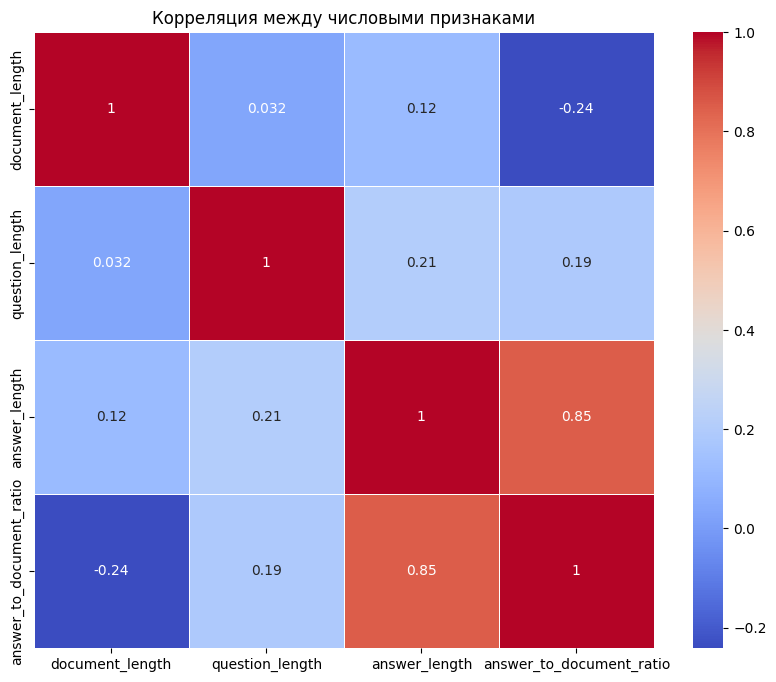

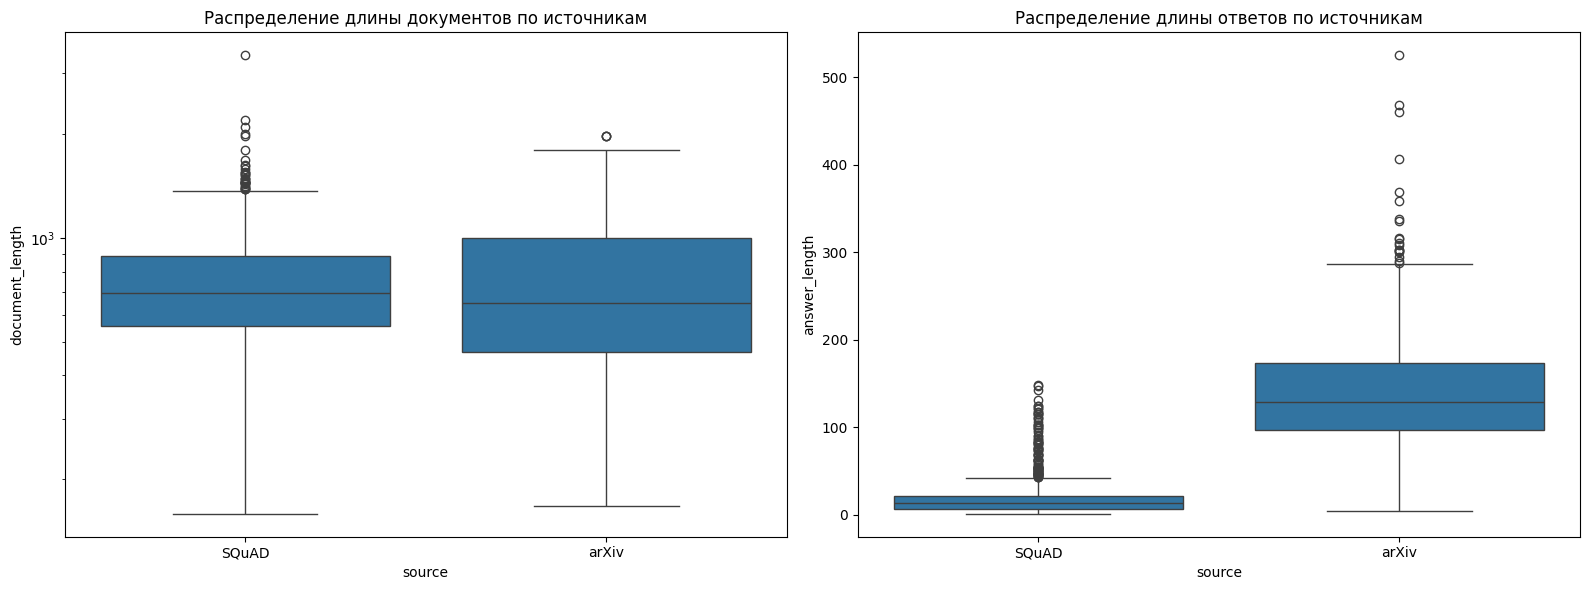

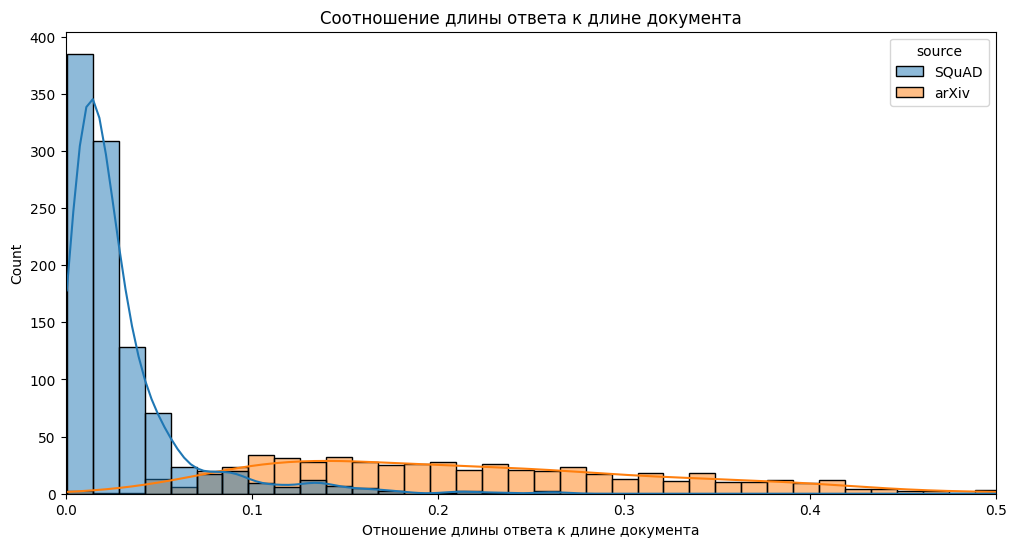

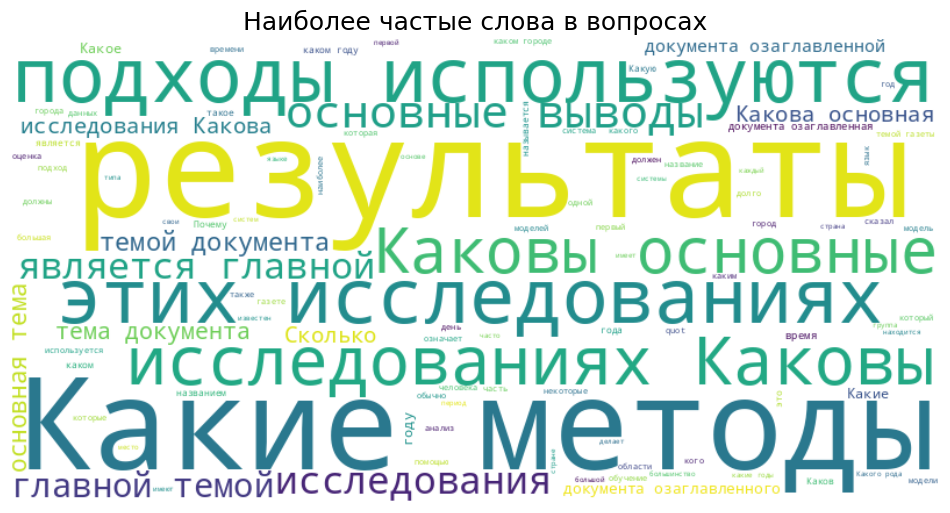

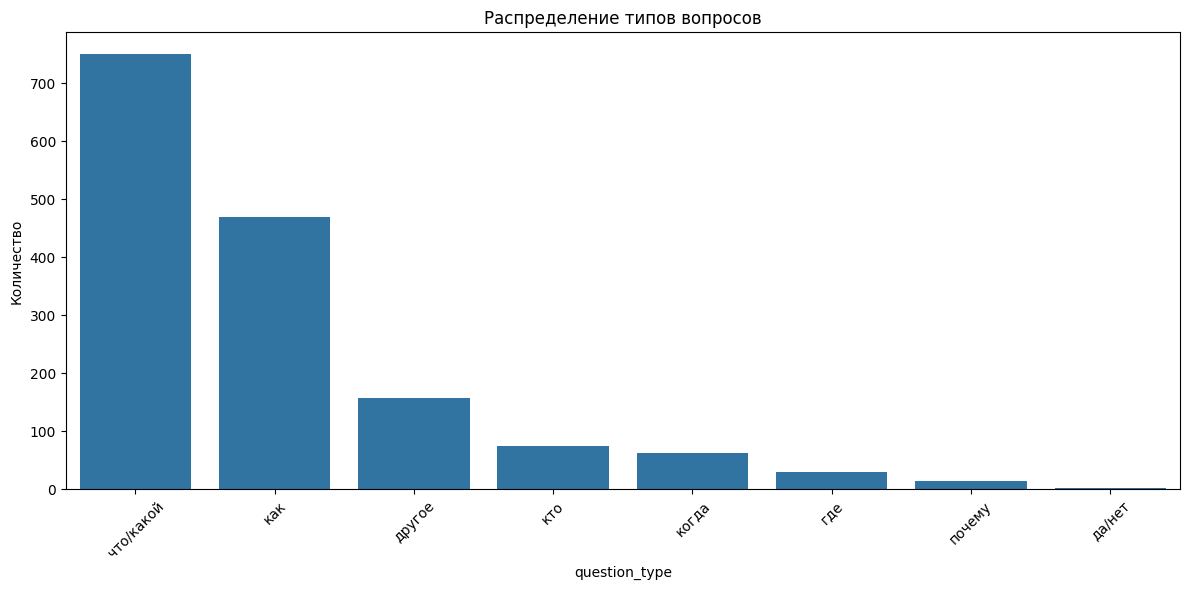

In [16]:
def perform_eda(df):

    print(f"Размер датасета: {df.shape}")

    print("\nРаспределение по источникам:")
    print(df['source'].value_counts())

    print("\nРаспределение по типам документов:")
    print(df['document_type'].value_counts())

    print("\nСтатистика по длине (в символах):")
    for col in ['document_length', 'question_length', 'answer_length']:
        print(f"\n{col}:")
        print(df[col].describe())

    # Корреляционный анализ числовых признаков
    numeric_cols = ['document_length', 'question_length', 'answer_length', 'answer_to_document_ratio']
    correlation = df[numeric_cols].corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation, annot=True, cmap='coolwarm', linewidths=0.5)
    plt.title('Корреляция между числовыми признаками')
    plt.show()

    # Визуализация распределения длины документов и ответов по источникам
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    sns.boxplot(x='source', y='document_length', data=df, ax=axes[0])
    axes[0].set_title('Распределение длины документов по источникам')
    axes[0].set_yscale('log')

    sns.boxplot(x='source', y='answer_length', data=df, ax=axes[1])
    axes[1].set_title('Распределение длины ответов по источникам')

    plt.tight_layout()
    plt.show()

    # Визуализация соотношения длины ответа к длине документа
    plt.figure(figsize=(12, 6))
    sns.histplot(data=df, x='answer_to_document_ratio', hue='source', bins=50, kde=True)
    plt.title('Соотношение длины ответа к длине документа')
    plt.xlabel('Отношение длины ответа к длине документа')
    plt.xlim(0, 0.5)
    plt.show()

    # Анализ наиболее частых слов в вопросах
    def get_wordcloud(text, title, stopwords_set=None):
        plt.figure(figsize=(12, 8))
        wordcloud = WordCloud(width=800, height=400, background_color='white',
                             stopwords=stopwords_set, max_words=100).generate(text)
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(title, fontsize=18)
        plt.show()

    stop_words = set(stopwords.words('russian'))
    all_questions = ' '.join(df['question_ru'])
    get_wordcloud(all_questions, 'Наиболее частые слова в вопросах', stop_words)

    def get_question_type(question):
        question = question.lower().strip()
        if any(phrase in question for phrase in ['что', 'какой', 'какая', 'какое', 'какие']):
            return 'что/какой'
        elif any(phrase in question for phrase in ['как', 'каков', 'каковы']):
            return 'как'
        elif any(phrase in question for phrase in ['кто']):
            return 'кто'
        elif any(phrase in question for phrase in ['когда']):
            return 'когда'
        elif any(phrase in question for phrase in ['где']):
            return 'где'
        elif any(phrase in question for phrase in ['почему']):
            return 'почему'
        elif any(phrase in question for phrase in ['какой']):
            return 'какой'
        elif any(phrase in question for phrase in ['может', 'могли', 'делает', 'делают']):
            return 'да/нет'
        else:
            return 'другое'

    df['question_type'] = df['question_ru'].apply(get_question_type)

    plt.figure(figsize=(12, 6))
    question_type_counts = df['question_type'].value_counts()
    sns.barplot(x=question_type_counts.index, y=question_type_counts.values)
    plt.title('Распределение типов вопросов')
    plt.xticks(rotation=45)
    plt.ylabel('Количество')
    plt.tight_layout()
    plt.show()

    return df

result_df = perform_eda(df_sample)


сохраняем датасет для дальнейшего пользования:

In [17]:
result_df.to_csv('hw1_result_df.csv', index=False, encoding='utf-8')